# SCSS-Net: Solar corona structures segmentation by deep learning


---


#          Part I: Segmentation of Coronal Holes


---


## Authors
**Š. Mackovjak $^1$, M. Harman * $^2$, V. Maslej-Krešňáková $^2$, P. Butka $^2$**


$^1$   Department of Space Physics, Institute of Experimental Physics, Slovak Academy of Sciences, Košice, Slovakia

$^2$  Department of Cybernetics and Artificial Intelligence, Faculty of Electrical Engineering and Informatics, Technical University of Košice, Košice, Slovakia

  \* main author of the code. For more details refer to repo created within Diploma thesis: https://github.com/matinus99/sun-segmentation

## Contact
All questions and comments related to this work can be addresed to:
Simon Mackovjak, Institute of Experimental Physics, Slovak Academy of Sciences, Watsonova 47, 04001 Košice, Slovakia, mackovjak(at)saske.sk


## Abstract
Structures in the solar corona are the main drivers of space weather processes that might directly or indirectly affect the Earth. Thanks to the most recent space-based solar observatories, with the capabilities to acquire high-resolution images continuously, the structures in the solar corona can be monitored over the years with the time resolution of minutes. For this purpose, we have developed a method for automatic segmentation of solar corona structures that is based on a deep learning approach utilizing Convolutional Neural Networks. The available input datasets have been examined together with the own dataset based on the manual annotation of the target structures. Indeed, the input dataset is the main limitation of the developed model's performance. Our *SCSS-Net* model provides results for coronal holes and active regions that could be compared with other generally used methods for automatic segmentation. Even more, it provides the universal procedure to identify structures in the solar corona thanks to the transfer learning technique. The outputs of the model can be then used for further statistical studies of connections between solar activity and space weather influence on Earth.



---







## Jupyter notebook – Segmentation of Coronal Holes
In the following, we present the data and Python methods used for analysis described in the article. Here is an overview of the Jupyter notebook:
1. Environment set-up
2. Data preprocessing
3. Deep learning approach
4. Results of SCSS-net







# 1. Environment set-up

* Clone SCSS-net repo and set-up the environment

In [1]:
import sys, os
!git clone https://github.com/space-lab-sk/scss-net.git
%cd scss-net
#!git pull origin main 
!pip install -r requirements.txt
sys.path.append('../scss-net/src')

fatal: destination path 'scss-net' already exists and is not an empty directory.
/Users/simon.mackovjak/OKF/scss-net/scss-net


* Import libraries

In [2]:
from mega import Mega
import zipfile
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import albumentations
from ImageDataAugmentor.image_data_augmentor import *

* Import local utilities

In [3]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics

# 2. Data preprocessing

Solar Dynamic Observatory / Atmospheric Imaging Assembly (SDO / AIA) data are used in this work. For more details refer to NASA web page: https://sdo.gsfc.nasa.gov. The data were downloaded via Helioviewer API: https://api.helioviewer.org. 

Annotations used in this notebook:
* Region Growth: https://github.com/observethesun/coronal_holes/blob/mnras2018/data/CH_abp.zip
    * Illarionov, E., & Tlatov, A.:2018, Segmentation of coronal holes in solar disc images with a convolutional neural network, Monthly Notices of the Royal Astronomical Society, 481(4), 5014–5021.
    * Tlatov, A., Tavastsherna, K., & Vasil’eva, V.: 2014, Coronal Holes in Solar Cycles 21 to 23, Solar Physics, 289.

Additional annotations used for the results in the article: 
* Custom: https://github.com/matinus99/sun-segmentation/blob/main/notebooks/data_custom.ipynb
* SPoCA: https://www.lmsal.com/hek/
* CHIMERA: https://solarmonitor.org/chimera.php

In [4]:
# DOWNLOAD preprocessed data and annotations for the purpose of this notebook (~610 MB)
mega = Mega()
m = mega.login()
print("Downloading ...")
try:
    m.download_url('https://mega.nz/file/sOBGiTwR#fjvzvxoLDFDKLv8EtLPBGqPUCo_T_I7y8f14n4eGu94')
except PermissionError:
    pass
print("Unzipping ...")
with zipfile.ZipFile("193.zip","r") as zip_ref:
    zip_ref.extractall("data")
print("DONE")

Unzipping ...
DONE


* Create lists with path to each file

In [5]:
imgs = glob.glob("./data/193_train/193(region_growth)/imgs/*.png")
masks = glob.glob("./data/193_train/193(region_growth)/masks/*.png")

print(f"Imgs number = {len(imgs)}\nMasks number = {len(masks)}")

Imgs number = 7872
Masks number = 7872


*   Set global variable


In [6]:
IMG_SIZE = 256  # resize imgs to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 100    # Set number of epochs

MODEL_NAME = "model_ch_region"                       # Specify model name
model_filename = f"./{MODEL_NAME}.h5"                  # Specify path where to save model

* Load, Resize, and Convert data to list of np arrays


In [7]:
imgs_list = []  # list of input images
masks_list = [] # list of annotations

for image, mask in zip(imgs, masks):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))


* Normalize data



In [8]:
# Data normalization: from (0; 255) to (0; 1)
x = np.asarray(imgs_list, dtype=np.float32)/255
y = np.asarray(masks_list, dtype=np.float32)/255


* Reshape data

In [9]:
# Reshape to (n_imgs, height, width, channels)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)



*   Split data


In [10]:
# Split data to Train set (90%) and Validation set (10%)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=None, shuffle=True)



*   Add real time *augumentations* to train set




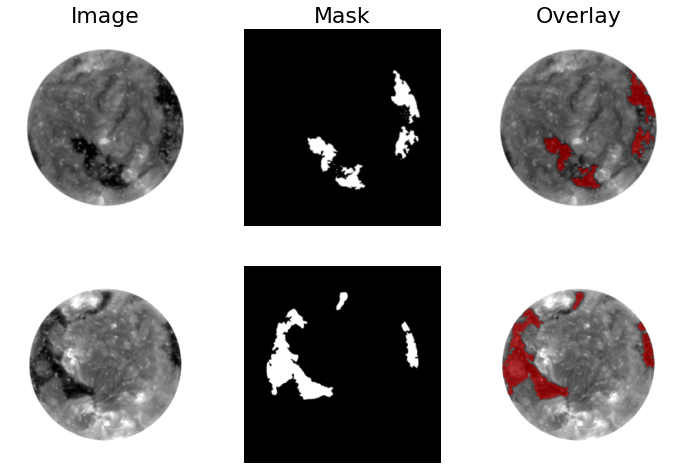

In [11]:
# Define augmentations for Train set
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=.5),
    albumentations.VerticalFlip(p=.5),
    albumentations.Rotate((-45, 45), p=.5, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomGamma((100, 150), p=.5),
    albumentations.RandomBrightnessContrast((.0, .2), (.0, .4), p=.5)
])

# Generator for images
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED)
img_gen = img_data_gen.flow(x_train, batch_size=BATCH_SIZE, shuffle=True)

# Generator for annotations
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED, label_augment_mode='mask')
mask_gen = mask_data_gen.flow(y_train, batch_size=BATCH_SIZE, shuffle=True)

# Train set with augmented data
train_gen = zip(img_gen, mask_gen)

# Plot samples of augmented imgs
x_sample, y_sample = next(train_gen)
plot_imgs(imgs=x_sample, masks=y_sample, n_imgs=2).show()

* Chcek shapes of input before training model

In [12]:
# input shape should be (256, 256, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}")

Input shape: (256, 256, 1)
Train shape: (7084, 256, 256, 1)  Val shape: (788, 256, 256, 1)


# 3. Deep learning approach

* Load model architecture imported from *model_scss_net.py* and prepare it for training

In [13]:
# Load model architecture with specific parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE        

# Set Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

* Train the model - uncomment the following code and train the model just if the satisfactory computational power is available (training took approx. 6 hours by using CPU Intel i58300H, RAM 32GB, GPU NVIDIA GeForce GTX1060 Max-Q 6GB)

In [14]:
# # Train model
# history = model.fit(
#     train_gen,
#     steps_per_epoch=STEPS,
#     epochs=EPOCHS,
#     validation_data=(x_val, y_val),
#     callbacks=[callback_checkpoint],
#     verbose=2)

# # Plot training history (Metrics and Loss)
# plot_metrics(history).show()

In [15]:
# if the previous cell with the training of the model was skipped, download already trained model (~100 MB)
print("Downloading ...")
try:
    m.download_url('https://mega.nz/file/BKhG2RAK#YA9dYeNRB8fSs7i-jHDDGvFVTqV0c5_5MWtW_tU1Qnk')
except PermissionError:
    pass
print("DONE")

DONE


* Load the trained model

In [16]:
model.load_weights(model_filename)

# 4. Results of SCSS-net

  ## 4.1 Results on validation set

* Predict new masks for validation set

In [17]:
 y_pred = model.predict(x_val)

* Plot Image sequence: 
 - Image: input image for SCSS-Net 
 - Mask: ground truth (i.e. annotation mask)
 - Prediction: output of SCSS-Net (i.e. predicted segmentation mask)
 - Overlay: predicted segmentation mask as an overlay on the input image

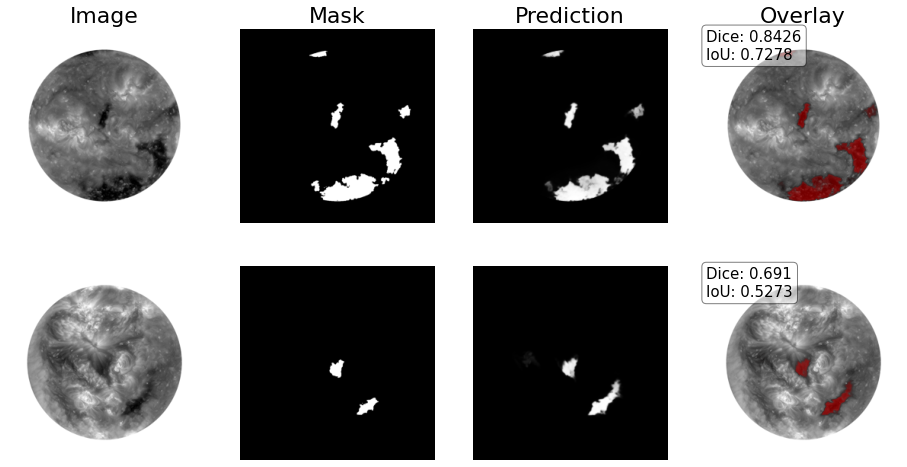

In [18]:
plot_imgs(imgs=x_val, masks=y_val, predictions=y_pred, n_imgs=2).show()

*  Calculate averaged metrics over validation set

In [19]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Threshold predicted values

dice = np.round(dice_np(y_val, y_pred), 4)
iou_val = np.round(iou_np(y_val, y_pred), 4)

dice_tresh = np.round(dice_np(y_val, y_pred_bin), 4)
iou_val_tresh = np.round(iou_np(y_val, y_pred_bin), 4)

print(f"Validation:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_val} IoU_tresh: {iou_val_tresh}\n")

Validation:
Dice: 0.8 Dice_tresh: 0.8754
 IoU: 0.6667 IoU_tresh: 0.7784



## 4.2 Results on test set

*  Prepare test set

In [20]:
imgs_test = glob.glob("./data/193_test/imgs/*.png")
masks_test = glob.glob("./data/193_test/masks(region)/*.png")

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

# Load data and convert imgs to np.array
imgs_test_list = []
masks_test_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_test_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_test_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_test_list, dtype=np.float32)/255
y_test = np.asarray(masks_test_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

Imgs number = 353
Masks number = 353


* Predict new masks for test set and plot image sequence:

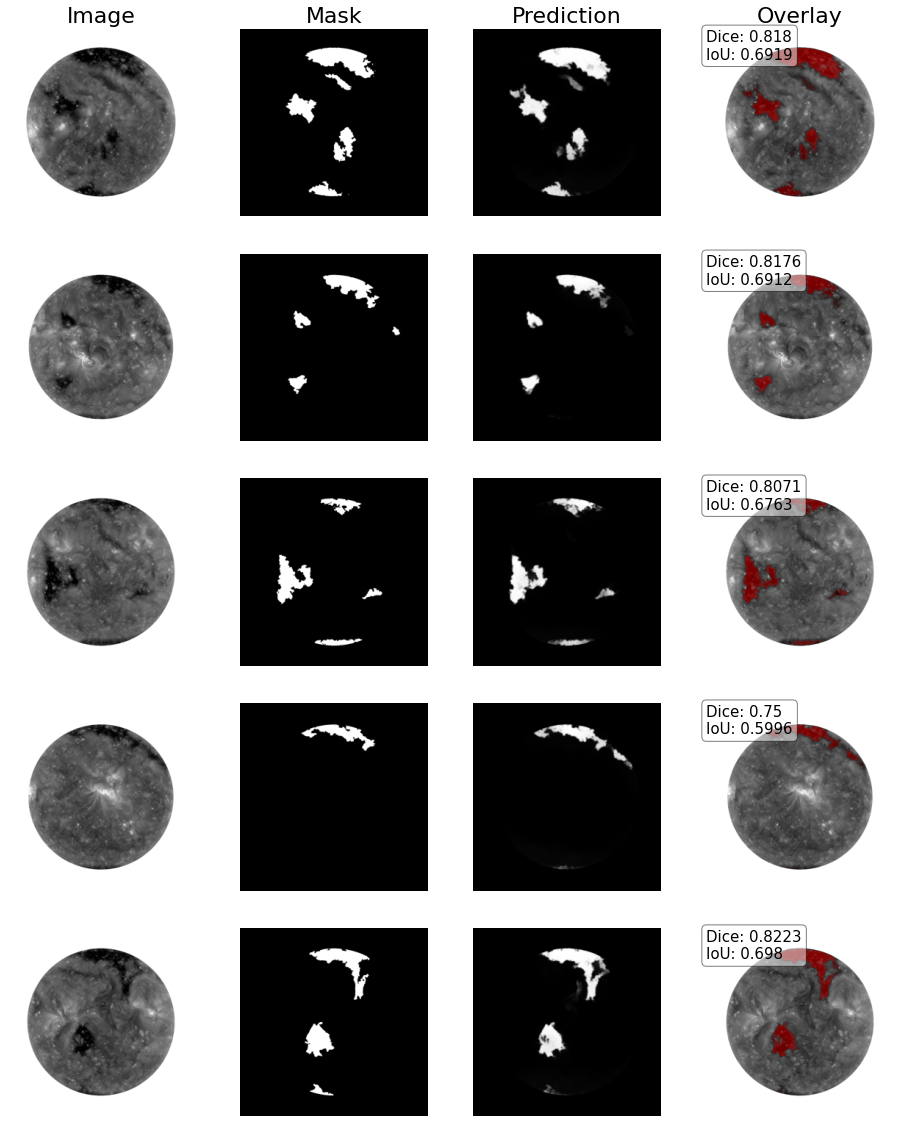

In [21]:
y_pred = model.predict(x_test)  
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=5).show()

* Calculate averaged metrics over test set

In [22]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Binarize predicted values

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Test:
Dice: 0.8059 Dice_tresh: 0.8786
 IoU: 0.6749 IoU_tresh: 0.7835

